In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"

# Natural Language Processing with TensorFlow

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-example-nlp-problems.png)
*A handful of example natural language processing (NLP) and natural language understanding (NLU) problems. These are also often referred to as sequence problems (going from one sequence to another).*

The main goal of [natural language processing (NLP)](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32) is to derive information from natural language.

Natural language is a broad term but you can consider it to cover any of the following:
* Text (such as that contained in an email, blog post, book, Tweet)
* Speech (a conversation you have with a doctor, voice commands you give to a smart speaker)

Under the umbrellas of text and speech there are many different things you might want to do.

If you're building an email application, you might want to scan incoming emails to see if they're spam or not spam (classification).

If you're trying to analyse customer feedback complaints, you might want to discover which section of your business they're for.

> 🔑 **Note:** Both of these types of data are often referred to as *sequences* (a sentence is a sequence of words). So a common term you'll come across in NLP problems is called *seq2seq*, in other words, finding information in one sequence to produce another sequence (e.g. converting a speech command to a sequence of text-based steps).

To get hands-on with NLP in TensorFlow, we're going to practice the steps we've used previously but this time with text data:

```
Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)
```

> 📖 **Resource:** For a great overview of NLP and the different problems within it, read the article [*A Simple Introduction to Natural Language Processing*](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32).

## What we're going to cover

Let's get specific hey?

* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script containing our helper functions can be [found on GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py).

In [2]:
# Downloading Helper Functions Script:
import wget
url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
file = wget.download(url)

In [3]:
# Importing Some Helper Functions from Downloaded Script:
from helper_functions import unzip_data, plot_loss_curves, compare_historys, create_tensorboard_callback

## Download a text dataset

Let's start by download a text dataset. We'll be using the [Real or Not?](https://www.kaggle.com/c/nlp-getting-started/data) dataset from Kaggle which contains text-based Tweets about natural disasters. 

The Real Tweets are actually about disasters, for example:

```
Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano
```

The Not Real Tweets are Tweets not about disasters (they can be on anything), for example:

```
'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote
```

For convenience, the dataset has been [downloaded from Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) (doing this requires a Kaggle account) and uploaded as a downloadable zip file. 

Note: The original downloaded data has not been altered to how you would download it from Kaggle.

In [4]:
# Downloading Text Data:
url = "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
file = wget.download(url)

# Unzipping The Data:
unzip_data("nlp_getting_started.zip")

Unzipping `nlp_getting_started.zip` gives the following 3 `.csv` files:
* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

## Visualizing a text dataset

Once you've acquired a new dataset to work with, what should you do first?

Explore it? Inspect it? Verify it? Become one with it?

All correct.

Right now, our text data samples are in the form of `.csv` files. For an easy way to make them visual, let's turn them into pandas DataFrame's.

> 📖 **Reading:** You might come across text datasets in many different formats. Aside from CSV files (what we're working with), you'll probably encounter `.txt` files and `.json` files too. For working with these type of files, I'd recommend reading the two following articles by RealPython:
* [How to Read and Write Files in Python](https://realpython.com/read-write-files-python/)
* [Working with JSON Data in Python](https://realpython.com/python-json/)

In [5]:
# Turning .csv Data into Pandas DataFrame:

import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
# Shuffling Training Data:
train_df_shuffled = train_df.sample(frac=1, random_state= 42)

In [8]:
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Notice how the training data has a `"target"` column.

We're going to be writing code to find patterns (e.g. different combinations of words) in the `"text"` column of the training dataset to predict the value of the `"target"` column.

The test dataset doesn't have a `"target"` column.

```
Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)
```

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-text-classification-inputs-and-outputs.png)
*Example text classification inputs and outputs for the problem of classifying whether a Tweet is about a disaster or not.*

In [9]:
# Testing Data:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# How Many Examples of Each Class are in Training Data:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Since we have two target values, we're dealing with a **binary classification** problem.

It's fairly balanced too, about 60% negative class (`target = 0`) and 40% positive class (`target = 1`).

Where, 

* `1` = a real disaster Tweet
* `0` = not a real disaster Tweet

In [11]:
# Total Number of Samples in Data:
print(f"Training Data Samples: {len(train_df_shuffled)}")
print(f"Test Data Samples: {len(test_df)}")
print(f"Total Number of Samples: {len(train_df_shuffled) + len(test_df)}")

Training Data Samples: 7613
Test Data Samples: 3263
Total Number of Samples: 10876


Alright, seems like we've got a decent amount of training and test data. If anything, we've got an abundance of testing examples, usually a split of 90/10 (90% training, 10% testing) or 80/20 is suffice.

Okay, time to visualize, let's write some code to visualize random text samples.

Question: Why visualize random samples? You could visualize samples in order but this could lead to only seeing a certain subset of data. Better to visualize a substantial quantity (100+) of random samples to get an idea of the different kinds of data you're working with. In machine learning, never underestimate the power of randomness.

In [12]:
# Visualizing 10 random Training Samples:

import random
random_index = random.randint(0, len(train_df)-10) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+10].itertuples():
    _,text,target = row
    print(f"Target: {target}", "(Real Disaster)" if target > 0 else "(Not Real Disaster)")
    print(f"Text:\n {text}\n")

Target: 0 (Not Real Disaster)
Text:
 'When you attack women's health you attack America's health.' Hillary Clinton shows how to #StandwithPP http://t.co/HXdG254dHO

Target: 0 (Not Real Disaster)
Text:
 Fatality  https://t.co/407V1y4HHg

Target: 0 (Not Real Disaster)
Text:
 I JUST SCREAMED SIDJSJDJEKDJSKDJD . I CANT STAND YOU ?? https://t.co/0Vcsafx9bY

Target: 0 (Not Real Disaster)
Text:
 Court back in session. Testimony continues with med. examiner discussing gunshot wounds #KerrickTrial

Target: 1 (Real Disaster)
Text:
 #NJTurnpike å_ #NJTurnpike Reopens Hours After Truck Fire In? http://t.co/oABJZtbVyZ http://t.co/GPBXRrDc07

Target: 1 (Real Disaster)
Text:
 The cryptic words that guided pilots on the Hiroshima bombing mission http://t.co/nSS5L64cvR #canada

Target: 1 (Real Disaster)
Text:
 EU states squabble over immigration. UK-France Eurotunnel deluged with migrants. One dead as 'thousands storm' tunnel http://t.co/vf6CKLmCSX

Target: 1 (Real Disaster)
Text:
 CLEARED: Crash in Ha

### Split data into training and validation sets

Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.

When our model trains (tries patterns in the Tweet samples), it'll only see data from the training set and we can see how it performs on unseen data using the validation set.

We'll convert our splits from pandas Series datatypes to lists of strings (for the text) and lists of ints (for the labels) for ease of use later.

To split our training dataset and create a validation dataset, we'll use Scikit-Learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method and dedicate 10% of the training samples to the validation set.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Use Train Test Split to split Training Data into Training and Validation Sets:

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                           train_df_shuffled["target"].to_numpy(),
                                                                           test_size= 0.1,
                                                                           random_state= 42)

In [15]:
# Check Lenghts:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [16]:
# Checking First 10 Examples in training sentences and it's labels:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

We've got a training set and a validation set containing Tweets and labels.

Our labels are in numerical form (`0` and `1`) but our Tweets are in string form.

Question: What do you think we have to do before we can use a machine learning algorithm with our text data? 

If you answered something along the lines of "turn it into numbers", you're correct. A machine learning algorithm requires its inputs to be in numerical form.

In NLP, there are two main concepts for turning text into numbers:
* **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  1. Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being `0`, "love" being `1` and "TensorFlow" being `2`. In this case, every word in a sequence considered a single **token**.
  2. **Character-level tokenization**, such as converting the letters A-Z to values `1-26`. In this case, every character in a sequence considered a single **token**.
  3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple **tokens**.
* **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word "dance" could be represented by the 5-dimensional vector `[-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]`. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings: 
  1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)) and an embedding representation will be learned during model training.
  2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-tokenization-vs-embedding.png)
*Example of **tokenization** (straight mapping from word to number) and **embedding** (richer representation of relationships between tokens).*

Question: What level of tokenzation should I use? What embedding should should I choose?

It depends on your problem. You could try character-level tokenization/embeddings and word-level tokenization/embeddings and see which perform best. You might even want to try stacking them (e.g. combining the outputs of your embedding layers using [`tf.keras.layers.concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate)). 

If you're looking for pre-trained word embeddings, [Word2vec embeddings](http://jalammar.github.io/illustrated-word2vec/), [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) and many of the options available on [TensorFlow Hub](https://tfhub.dev/s?module-type=text-embedding) are great places to start.

Note: Much like searching for a pre-trained computer vision model, you can search for pre-trained word embeddings to use for your problem. Try searching for something like "use pre-trained word embeddings in TensorFlow".

### Text vectorization (tokenization)


We'll practice tokenzation (mapping our words to numbers) first.

To tokenize our words, we'll use the helpful preprocessing layer [`tf.keras.layers.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens. 
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [18]:
# Using Default Parameters for TextVectorization:

text_vectorizer = TextVectorization(max_tokens= None, # how many words in the vocabulary (all of the different words in your text)
                                   standardize= "lower_and_strip_punctuation", # how to process text
                                   split= "whitespace", # how to split tokens
                                   ngrams= None,  # create groups of n-words?
                                   output_mode= "int", # how to map tokens to numbers
                                   output_sequence_length= None) # how long should the output sequence of tokens be?
                                   # pad_to_max_tokens=True) # Not valid if using max_tokens=None

We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_tokens` and `output_sequence_length`.

For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (`10,000`, `20,000`, `30,000`) or the exact number of unique words in your text (e.g. `32,179`) are common values.

For our use case, we'll use `10,000`.

And for the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [19]:
train_sentences[0]

'@mogacola @zamtriossu i screamed after hitting tweet'

In [20]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [21]:
len(train_sentences[0].split())

7

In [22]:
# Average Number of Tokens(Words) in Training Tweets:
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [23]:
# Setup Text Vectorization with custom parameter values:

max_vocab_lenghth = 10000 # max number of words to have in our vocabulary
max_lengths = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens= max_vocab_lenghth,
                                   output_mode= "int",
                                   output_sequence_length= max_lengths)

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [24]:
# Fit The Text Vectorizor to The Training Text:
text_vectorizer.adapt(train_sentences)

In [25]:
# Create a Sample Sentence and Vectorize it:
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

It seems we've got a way to turn our text into numbers (in this case, word-level tokenization). Notice the 0's at the end of the returned tensor, this is because we set `output_sequence_length=15`, meaning no matter the size of the sequence we pass to `text_vectorizer`, it always returns a sequence with a length of 15.

How about we try our `text_vectorizer` on a few random sentences?

In [26]:
# Chose a Random Sentence from Training Data and Vectorize it:
random_sentence = random.choice(train_sentences)
print(f"Original Text:\n {random_sentence} \n\n Vectorized Version: {text_vectorizer([random_sentence])}")

Original Text:
 OMEGA MEN Writer Explores Terrorism Religion In an 'Epic KYLE RAYNER Story' https://t.co/utc7pdIdfo via @Newsarama 

 Vectorized Version: [[4998  646 2596 5683  361 4765    4   39 1683 2907 4795  451    1   49
  5049]]


We can check the unique tokens in our vocabulary using the `get_vocabulary()` method.

In [27]:
# Get the Unique Words in Vocabulary of Text Vectorizer:
words_in_vocab = text_vectorizer.get_vocabulary() # Get All of The Unique Words from Training Data.
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of Words in Vocabulary: {len(words_in_vocab)}")
print(f"Top 5 Most Common Words: {top_5_words}")
print(f"Bottom 5 Least Common Words: {bottom_5_words}")

Number of Words in Vocabulary: 10000
Top 5 Most Common Words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 Least Common Words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. 

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

In [28]:
from tensorflow.keras.layers import Embedding

In [29]:
tf.random.set_seed(42)

embedding = Embedding(input_dim= max_vocab_lenghth, # set input shape
                     output_dim= 128, # set size of embedding vector
                     embeddings_initializer= "uniform", # default, intialize randomly
                     name= "Embedding_1")

In [30]:
embedding

In [31]:
# Getting a Random Sentence from Training Sentences to Embed:

random_sentence = random.choice(train_sentences)
print(f"Original Text:\n {random_sentence}")
print(f"Embedded Version:\n")

# Embed The Random Sentence (Turn it into Numerical Representation (into Dense Vectors of Fixed Size))
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Text:
 I liked a @YouTube video from @itsjustinstuart http://t.co/Mnkaji2Q1N GUN RANGE MAYHEM!
Embedded Version:



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0460597 ,  0.03804063, -0.03829674, ..., -0.00508253,
          0.01667095, -0.01724137],
        [-0.04077094,  0.01546328, -0.01831574, ..., -0.00259745,
          0.04152742, -0.02988878],
        [-0.02992166, -0.02081641, -0.01315315, ..., -0.03517996,
         -0.00051598,  0.03493518],
        ...,
        [-0.01092371, -0.02878962,  0.02859397, ..., -0.02740737,
         -0.00322539,  0.00704388],
        [-0.01092371, -0.02878962,  0.02859397, ..., -0.02740737,
         -0.00322539,  0.00704388],
        [-0.01092371, -0.02878962,  0.02859397, ..., -0.02740737,
         -0.00322539,  0.00704388]]], dtype=float32)>

In [32]:
# Check Out Single Token(Word)'s Embedding:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.0460597 ,  0.03804063, -0.03829674,  0.01892847, -0.036492  ,
        0.01875836,  0.00292146, -0.02066691,  0.036735  , -0.00024616,
       -0.02104921,  0.00053839, -0.03829206,  0.00691019, -0.00425833,
        0.02211838, -0.02144653, -0.00576765,  0.03214306, -0.01266623,
       -0.01045831,  0.01925762, -0.02909985, -0.02010917, -0.02585332,
        0.01531984, -0.02406885,  0.02465094,  0.02084673, -0.03328145,
       -0.02245748,  0.02693148,  0.01714584, -0.00442461, -0.02266127,
       -0.02624686,  0.01599591,  0.02210225,  0.03474731, -0.04277036,
        0.02586401, -0.01845689, -0.00261373,  0.00069027,  0.03018254,
       -0.03481648, -0.02938499, -0.04470915,  0.04221255,  0.03434141,
       -0.01175996,  0.02687981,  0.00510976,  0.01944102,  0.04789125,
       -0.03843312, -0.03946476,  0.0318543 , -0.00305711, -0.02712013,
       -0.04754807,  0.00940394, -0.03439174, -0.02906373, -0.04402152,
        0.045762

In [33]:
random_sentence.split()[0]

'I'

## Modelling a text dataset

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-inputs-and-outputs-with-shapes-and-models-were-going-to-build.png)
*Once you've got your inputs and outputs prepared, it's a matter of figuring out which machine learning model to build in between them to bridge the gap.*

Now that we've got a way to turn our text data into numbers, we can start to build machine learning models to model it.

To get plenty of practice, we're going to build a series of different models, each as its own experiment. We'll then compare the results of each model and see which one performed best.

More specifically, we'll be building the following:
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). This was chosen via referring to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [35]:
# Creating A Pipeline For Tokenization and Modelling:
model_0 = Pipeline([("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                   ("clf", MultinomialNB())]) # model the text

In [36]:
# Fitting Training Data and Labels into Pipeline:
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [37]:
# Evaluating The Base Line Model:
baseline_score = model_0.score(val_sentences, val_labels)
baseline_score

0.7926509186351706

In [38]:
# Making Predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

### Creating an evaluation function for our model experiments

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:
* Accuracy
* Precision
* Recall
* F1-score

Note: Since we're dealing with a classification problem, the above metrics are the most appropriate. If we were working with a regression problem, other metrics such as MAE (mean absolute error) would be a better choice.

In [39]:
# Creating an Evaluation Function:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
      Calculates model accuracy, precision, recall and f1 score of a binary classification model.

      Args:
      -----
      y_true = true labels in the form of a 1D array
      y_pred = predicted labels in the form of a 1D array

      Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate Model Accuracy:
    model_accuracy= accuracy_score(y_true, y_pred) * 100
    
    # Calculate Model Precision, Recall and F1-Score:
    model_precision, model_recall, model_F1, _ = precision_recall_fscore_support(y_true, y_pred, average= "weighted")
    
    model_results = {"Accuracy": model_accuracy,
                    "Precision": model_precision,
                    "Recall": model_recall,
                    "F1-Score": model_F1}
    
    return model_results

In [40]:
# Getting Results for Baseline Model:
baseline_results = calculate_results(y_true= val_labels,
                                    y_pred= baseline_preds)
baseline_results

{'Accuracy': 79.26509186351706,
 'Precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1-Score': 0.7862189758049549}

### Model 1: A simple dense model

The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer. 

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

If the previous sentence sounds like a mouthful, it'll make sense when we code it out (remember, if in doubt, code it out).

And since we're going to be building a number of TensorFlow deep learning models, we'll import our `create_tensorboard_callback()` function from `helper_functions.py` to keep track of the results of each. 

In [41]:
from helper_functions import create_tensorboard_callback
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dense
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [42]:
# Creating a Directory to Save TensorBoard Logs:
SAVE_DIR = "model_logs"

In [43]:
# Building a Model with Functional API:

inputs = Input(shape=(1,), dtype= tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = Dense(1, activation= "sigmoid")(x)  # create the output layer, want binary outputs so use sigmoid activation
model_1 = Model(inputs, outputs, name= "Model_1_Dense") # construct the model

In [44]:
# Model 1 Summary:
model_1.summary()

Model: "Model_1_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 Embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [45]:
# Compiling The Model:
model_1.compile(optimizer= Adam(),
               loss= BinaryCrossentropy(),
               metrics= ["accuracy"])

In [46]:
# Fit The Model:
model_1_history = model_1.fit(x=train_sentences,
                             y=train_labels,
                             validation_data= (val_sentences, val_labels),
                             callbacks= [create_tensorboard_callback(dir_name= SAVE_DIR,
                                                experiment_name= "Model_1_Dense")],
                             epochs= 5)

Saving TensorBoard log files to: model_logs/Model_1_Dense/20240517-151135
Epoch 1/5

215/215 [==============================] - 32s 15ms/step - loss: 0.6098 - accuracy: 0.6939 - val_loss: 0.5365 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4416 - accuracy: 0.8186 - val_loss: 0.4693 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3467 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2851 - accuracy: 0.8914 - val_loss: 0.4640 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2382 - accuracy: 0.9113 - val_loss: 0.4765 - val_accuracy: 0.7861


In [47]:
# Evaluating The Model:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4765 - accuracy: 0.7861


[0.47651204466819763, 0.7860892415046692]

In [48]:
# Predictions (these come back in the form of probabilities)
model_1_pred_prob = model_1.predict(val_sentences)
model_1_pred_prob

24/24 [==============================] - 1s 3ms/step


array([[4.14379179e-01],
       [7.43882835e-01],
       [9.97855425e-01],
       [1.08832240e-01],
       [1.05136089e-01],
       [9.35031474e-01],
       [9.11083639e-01],
       [9.92830813e-01],
       [9.67259705e-01],
       [2.63125539e-01],
       [1.17619753e-01],
       [7.09145665e-01],
       [5.32327779e-02],
       [2.19969049e-01],
       [5.47746709e-03],
       [1.58651993e-01],
       [2.62049213e-02],
       [1.00201473e-01],
       [2.42151678e-01],
       [5.54648221e-01],
       [9.13423598e-01],
       [4.01339643e-02],
       [4.54459339e-01],
       [1.00851096e-01],
       [9.58328903e-01],
       [9.98982549e-01],
       [3.41128893e-02],
       [7.17111528e-02],
       [2.63802223e-02],
       [2.09587142e-01],
       [5.72296560e-01],
       [2.37163976e-01],
       [5.14427483e-01],
       [2.15842381e-01],
       [5.27274072e-01],
       [5.62030375e-02],
       [9.94588435e-01],
       [1.42260641e-01],
       [3.64319794e-02],
       [9.98426735e-01],


Since our final layer uses a sigmoid activation function, we get our predictions back in the form of probabilities.

To convert them to prediction classes, we'll use `tf.round()`, meaning prediction probabilities below 0.5 will be rounded to 0 and those above 0.5 will be rounded to 1.

Note: In practice, the output threshold of a sigmoid prediction probability doesn't necessarily have to 0.5. For example, through testing, you may find that a cut off of 0.25 is better for your chosen evaluation metrics. A common example of this threshold cutoff is the [precision-recall tradeoff](https://en.wikipedia.org/wiki/Precision_and_recall#Introduction) (search for the keyword "tradeoff" to learn about the phenomenon).

In [49]:
# Convert Model's Prediction Probabilities to Labels:
model_1_preds = tf.squeeze(tf.round(model_1_pred_prob))

In [50]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [51]:
# Calculating Model 1 Results:
model_1_results = calculate_results(y_true= val_labels,
                                   y_pred= model_1_preds)
model_1_results

{'Accuracy': 78.60892388451444,
 'Precision': 0.7903277546022673,
 'Recall': 0.7860892388451444,
 'F1-Score': 0.7832971347503846}

In [52]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

Our first model (`model_1`) contained an embedding layer (`embedding`) which learned a way of representing words as feature vectors by passing over the training data.

Hearing this for the first few times may sound confusing.

So to further help understand what a text embedding is, let's visualize the embedding our model learned.

In [53]:
# Get The Vocabulary from the text Vectorization Layer:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [54]:
model_1.summary()

Model: "Model_1_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 Embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [55]:
# Get The Weight Matrix of Embedding Layer
# (these are the numerical patterns between the text in the training dataset the model has learned):

embed_weights = model_1.get_layer("Embedding_1").get_weights()[0]
embed_weights

array([[-0.02247844, -0.03965262,  0.01498428, ..., -0.04097297,
         0.00943387,  0.01908769],
       [ 0.02272835,  0.01039805,  0.00876818, ...,  0.0084563 ,
         0.03176671, -0.024345  ],
       [-0.03652832, -0.02903925,  0.01280243, ..., -0.03135797,
         0.04530582,  0.04661977],
       ...,
       [-0.04373081, -0.02799361, -0.03452826, ..., -0.04717828,
        -0.0267789 ,  0.02130501],
       [-0.08693402, -0.07948836, -0.07148296, ..., -0.04098297,
         0.01777889,  0.01836477],
       [-0.10987895, -0.0658111 , -0.07936088, ..., -0.03084402,
         0.08824226,  0.03541903]], dtype=float32)

In [56]:
# same size as vocab size and embedding_dim (each word is a embedding_dim size vector)
embed_weights.shape

(10000, 128)

Now we've got these two objects, we can use the [Embedding Projector tool](http://projector.tensorflow.org/_) to visualize our embedding. 

To use the Embedding Projector tool, we need two files:
* The embedding vectors (same as embedding weights).
* The meta data of the embedding vectors (the words they represent - our vocabulary).

Right now, we've got of these files as Python objects. To download them to file, we're going to [use the code example available on the TensorFlow word embeddings tutorial page](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk).

In [57]:
 # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
   if num == 0: 
      continue # skip padding token
   vec = embed_weights[num]
   out_m.write(word + "\n") # write words to file
   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
 out_v.close()
 out_m.close()

Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:
1. Go to  http://projector.tensorflow.org/
2. Click on "Load data"
3. Upload the two files you downloaded (`embedding_vectors.tsv` and `embedding_metadata.tsv`)
4. Explore
5. Optional: You can share the data you've created by clicking "Publish"

Are words with similar meanings close together?

Remember, they might not be. The embeddings we downloaded are how our model interprets words, not necessarily how we interpret them. 

Also, since the embedding has been learned purely from Tweets, it may contain some strange values as Tweets are a very unique style of natural language.

> 🤔 **Question:** Do you have to visualize embeddings every time?

No. Although helpful for gaining an intuition of what natural language embeddings are, it's not completely necessary. Especially as the dimensions of your vocabulary and embeddings grow, trying to comprehend them would become an increasingly difficult task.

## Recurrent Neural Networks (RNN's)

For our next series of modelling experiments we're going to be using a special kind of neural network called a **Recurrent Neural Network (RNN)**.

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (`X`) and compute an output (`y`) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word dog. 

See what happened there? 

I put the word "dog" at the end which is a valid word but it doesn't make sense in the context of the rest of the sentence.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence. 

For a simple example, take two sentences:
1. Massive earthquake last week, no?
2. No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:
* **One to one:** one input, one output, such as image classification.
* **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:
* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

For a deeper understanding of what's happening behind the scenes of the code we're about to write, I'd recommend the following resources:

> * [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU) - explains the background of recurrent neural networks and introduces LSTMs.
> * [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
> * [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.

### Model 2: LSTM

We're going to start with an LSTM-powered RNN.

To harness the power of the LSTM cell (LSTM cell and LSTM layer are often used interchangably) in TensorFlow, we'll use [`tensorflow.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-RNN-architecture-coloured-block-edition.png)
*Coloured block example of the structure of an recurrent neural network.*

Our model is going to take on a very similar structure to `model_1`:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main difference will be that we're going to add an LSTM layer between our embedding and output.

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (`model_2_embedding`) for our model. The `text_vectorizer` layer can be reused since it doesn't get updated during training.

> 🔑 **Note:** The reason we use a new embedding layer for each model is since the embedding layer is a *learned* representation of words (as numbers), if we were to use the same embedding layer (`embedding_1`) for each model, we'd be mixing what one model learned with the next. And because we want to compare our models later on, starting them with their own embedding layer each time is a better idea.

In [58]:
from tensorflow.keras.layers import LSTM

In [59]:
# Creating Embedding Layer for Model (new embedding layer for each model):
tf.random.set_seed(42)
model_2_embedding = Embedding(input_dim= max_vocab_lenghth,
                             output_dim= 128,
                             embeddings_initializer= "uniform",
                             name= "Embedding_2")

In [60]:
# Creating Model 2 (With LSTM):

inputs = Input(shape=(1,), dtype= tf.string)
x = text_vectorizer(inputs)
x = model_2_embedding(x)
# print(x.shape)
# x = LSTM(units= 64, return_sequences= True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
# print(x.shape)
x = LSTM(units= 64)(x) # return vector for whole sequence
# print(x.shape)
# x = Dense(64, activation= "relu" )(x) # optional dense layer on top of output of LSTM cell
outputs = Dense(1, activation= "sigmoid")(x)
model_2 = Model(inputs, outputs, name= "Model_2_LSTM")

Note: Reading the documentation for the [TensorFlow LSTM layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM), you'll find a plethora of parameters. Many of these have been tuned to make sure they compute as fast as possible. The main ones you'll be looking to adjust are `units` (number of hidden units) and `return_sequences` (set this to `True` when stacking LSTM or other recurrent layers).

Now we've got our LSTM model built, let's compile it using `"binary_crossentropy"` loss and the Adam optimizer.

In [61]:
# Model 2 Summary:
model_2.summary()

Model: "Model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 Embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

If you'd like to know where this number comes from, I recommend going through the above resources as well the following on calculating the number of parameters in an LSTM cell:
* [Stack Overflow answer to calculate the number of parameters in an LSTM cell](https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network) by Marcin Możejko
* [Calculating number of parameters in a LSTM unit and layer](https://medium.com/@priyadarshi.cse/calculating-number-of-parameters-in-a-lstm-unit-layer-7e491978e1e4) by Shridhar Priyadarshi

In [62]:
# Compile The Model:
model_2.compile(optimizer= Adam(),
               loss= BinaryCrossentropy(),
               metrics= ["accuracy"])

In [63]:
# Fit The Model:
model_2_history = model_2.fit(train_sentences,
                             train_labels,
                             epochs= 5,
                             validation_data= (val_sentences, val_labels),
                             callbacks= [create_tensorboard_callback(dir_name= SAVE_DIR,
                                                                    experiment_name= "Model_2_LSTM")])

Saving TensorBoard log files to: model_logs/Model_2_LSTM/20240517-151219
Epoch 1/5
215/215 [==============================] - 14s 22ms/step - loss: 0.5129 - accuracy: 0.7415 - val_loss: 0.4559 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3194 - accuracy: 0.8707 - val_loss: 0.5077 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2196 - accuracy: 0.9177 - val_loss: 0.5801 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1541 - accuracy: 0.9451 - val_loss: 0.6278 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1077 - accuracy: 0.9597 - val_loss: 0.8459 - val_accuracy: 0.7651


In [64]:
# Making Predictions Using Model 2 on Validation Data:
model_2_pred_prob = model_2.predict(val_sentences)
model_2_pred_prob[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.00889554],
       [0.78459334],
       [0.99916095],
       [0.05735538],
       [0.00373509],
       [0.9992364 ],
       [0.8388406 ],
       [0.99958825],
       [0.99940354],
       [0.3913708 ]], dtype=float32)

In [65]:
# Converting Model's Prediction Probabilites to Labels:
model_2_preds = tf.squeeze(tf.round(model_2_pred_prob))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [66]:
# Calculating Model 2 Results:
model_2_results = calculate_results(y_true= val_labels,
                                   y_pred= model_2_preds)
model_2_results

{'Accuracy': 76.50918635170603,
 'Precision': 0.7666862986020204,
 'Recall': 0.7650918635170604,
 'F1-Score': 0.7628949062414964}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

Resource: resources to learn more:
* [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) Wikipedia page
* [Understanding GRU networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) by Simeon Kostadinov

To use the GRU cell in TensorFlow, we can call the [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) class.

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

Again, the only difference will be the layer(s) we use between the embedding and the output.

In [67]:
from tensorflow.keras.layers import GRU

In [68]:
# Creating Embedding Layer for Model (new embedding layer for each model):
model_3_embedding = Embedding(input_dim= max_vocab_lenghth,
                             output_dim= 128,
                             embeddings_initializer= "uniform",
                             name= "Embedding_3")

In [69]:
# Creating MOdel 3 (With GRU):

tf.random.set_seed(42)
inputs = Input(shape= (1,), dtype= tf.string)
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# print(x.shape)
x = GRU(64)(x) # stacking recurrent cells requires return_sequences=True
# print(x.shape)
# x = LSTM(64, return_sequences= True)(x)
# print(x.shape)
# x = GRU(units= 64)(x)
# print(x.shape)
# x = Dense(64, activation= "relu")(x)
outputs = Dense(1, activation= "sigmoid")(x)

model_3 = Model(inputs, outputs, name= "Model_3_GRU")

In [70]:
# Summary of Model 3:
model_3.summary()

Model: "Model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 Embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [71]:
# Compile The Model:
model_3.compile(optimizer= Adam(),
               loss= BinaryCrossentropy(),
               metrics= ["accuracy"])

In [72]:
# Fit Model 3:

model_3_history = model_3.fit(train_sentences,
                             train_labels,
                             validation_data= (val_sentences, val_labels),
                             epochs= 5,
                             callbacks= [create_tensorboard_callback(dir_name= SAVE_DIR,
                                                                    experiment_name= "M0del_3_GRU")])

Saving TensorBoard log files to: model_logs/M0del_3_GRU/20240517-151251
Epoch 1/5
215/215 [==============================] - 11s 22ms/step - loss: 0.5274 - accuracy: 0.7266 - val_loss: 0.4557 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3182 - accuracy: 0.8680 - val_loss: 0.4893 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2160 - accuracy: 0.9181 - val_loss: 0.5606 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1537 - accuracy: 0.9476 - val_loss: 0.6240 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1171 - accuracy: 0.9597 - val_loss: 0.6063 - val_accuracy: 0.7743


In [73]:
# Making Predictions Using Model 3 on Validation Data:
model_3_pred_prob = model_3.predict(val_sentences)
model_3_pred_prob[:10]

24/24 [==============================] - 21s 7ms/step


array([[0.3875993 ],
       [0.8942472 ],
       [0.9967889 ],
       [0.14872767],
       [0.01307077],
       [0.99118817],
       [0.7652192 ],
       [0.9975328 ],
       [0.99663323],
       [0.38831314]], dtype=float32)

In [74]:
# Converting Model's Prediction Probabilites to Labels:
model_3_preds = tf.squeeze(tf.round(model_3_pred_prob))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [75]:
# Calculating Model 3 Results:
model_3_results = calculate_results(y_true= val_labels,
                                   y_pred= model_3_preds)
model_3_results

{'Accuracy': 77.42782152230971,
 'Precision': 0.7749000605693519,
 'Recall': 0.7742782152230971,
 'F1-Score': 0.7728247037302157}

### Model 4: Bidirectonal RNN model 

Now we're going to look into another kind of RNN, the bidirectional RNN.

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Once again, TensorFlow helps us out by providing the [`tensorflow.keras.layers.Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) class. We can use the `Bidirectional` class to wrap our existing RNNs, instantly making them bidirectional.

In [76]:
from tensorflow.keras.layers import Bidirectional

In [77]:
# Creating Embedding Layer for Model (new embedding layer for each model):
model_4_embedding = Embedding(input_dim= max_vocab_lenghth,
                             output_dim= 128,
                             embeddings_initializer= "uniform",
                             name= "Embedding_4")

In [78]:
# Creating Model 4 (BiDirectional RNN):

tf.random.set_seed(42)

inputs = Input(shape= (1,), dtype= tf.string)
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = Bidirectional(LSTM(64))(x)
outputs = Dense(1, activation= "sigmoid")(x)

model_4 = Model(inputs, outputs, name= "Model_4_BiDirectional")

In [79]:
# Summary of Model 4:
model_4.summary()

Model: "Model_4_BiDirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 Embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

You can use the `Bidirectional` wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.

In [80]:
# Compile The Model:
model_4.compile(optimizer= Adam(),
               loss= BinaryCrossentropy(),
               metrics= ["accuracy"])

In [81]:
# Fit Model 4:

model_4_history = model_4.fit(train_sentences,
                             train_labels,
                             validation_data= (val_sentences, val_labels),
                             epochs= 5,
                             callbacks= [create_tensorboard_callback(dir_name= SAVE_DIR,
                                                                    experiment_name= "Model_4_Bidirectional")])

Saving TensorBoard log files to: model_logs/Model_4_Bidirectional/20240517-151340
Epoch 1/5
215/215 [==============================] - 15s 25ms/step - loss: 0.5088 - accuracy: 0.7453 - val_loss: 0.4591 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3131 - accuracy: 0.8740 - val_loss: 0.5106 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2152 - accuracy: 0.9177 - val_loss: 0.5687 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1531 - accuracy: 0.9470 - val_loss: 0.6236 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1090 - accuracy: 0.9632 - val_loss: 0.6738 - val_accuracy: 0.7717


In [82]:
# Making Predictions Using Model 4 on Validation Data:
model_4_pred_prob = model_4.predict(val_sentences)
model_4_pred_prob[:10]

24/24 [==============================] - 2s 10ms/step


array([[0.02563202],
       [0.8609178 ],
       [0.99859834],
       [0.15583314],
       [0.00421664],
       [0.9923472 ],
       [0.9217396 ],
       [0.99950266],
       [0.9993944 ],
       [0.3938503 ]], dtype=float32)

In [83]:
# Converting Model's Prediction Probabilites to Labels:
model_4_preds = tf.squeeze(tf.round(model_4_pred_prob))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [84]:
# Calculating Model 4 Results:
model_4_results = calculate_results(y_true= val_labels,
                                   y_pred= model_4_preds)
model_4_results

{'Accuracy': 77.16535433070865,
 'Precision': 0.7713194941541398,
 'Recall': 0.7716535433070866,
 'F1-Score': 0.7710516132762637}

## Convolutional Neural Networks for Text

You might've used convolutional neural networks (CNNs) for images before but they can also be used for sequences.

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following: 

```
Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)
```

You might be thinking "that just looks like the architecture layout we've been using for the other models..."

And you'd be right.

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer followed by a [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) layer.

> 📖 **Resource:** The intuition here is explained succinctly in the paper [*Understanding Convolutional Neural Networks for Text Classification*](https://www.aclweb.org/anthology/W18-5408.pdf), where they state that CNNs classify text through the following steps:
1. 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name is Daniel").
2. Max-pooling over time extracts the relevant ngrams for making a decision.
3. The rest of the network classifies the text based on this information.

### Model 5: Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a **temporal convolution**) in action.

We'll first create an embedding of a sample of text and experiment passing it through a `Conv1D()` layer and `GlobalMaxPool1D()` layer.

In [85]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D

In [86]:
# Testing of Embedding, 1D Convolution Layer and Global Max Pool 1D Layer:

# turn target sentence into embedding
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))

# convolve over target sequence 5 words at a time
conv_1d = Conv1D(filters=32, kernel_size=5, activation= "relu")

# pass embedding through 1D convolutional layer
conv_1d_output = conv_1d(embedding_test)

# get the most important features
max_pool= GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

Notice the output shapes of each layer.

The embedding has an output shape dimension of the parameters we set it to (`input_length=15` and `output_dim=128`).

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

In [87]:
# Outputs of Each Layer:
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.01707011, -0.00272389,  0.01920843, ...,  0.0084233 ,
          -0.02676494,  0.01860629],
         [-0.02915313, -0.05756824,  0.00145885, ..., -0.01948511,
           0.07554968,  0.06541969],
         [-0.03938187, -0.03063604, -0.02266128, ..., -0.04511965,
           0.00941444,  0.04471743],
         ...,
         [-0.02247844, -0.03965262,  0.01498428, ..., -0.04097297,
           0.00943387,  0.01908769],
         [-0.02247844, -0.03965262,  0.01498428, ..., -0.04097297,
           0.00943387,  0.01908769],
         [-0.02247844, -0.03965262,  0.01498428, ..., -0.04097297,
           0.00943387,  0.01908769]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.17456052, 0.        , 0.03054252, 0.01986644, 0.        ,
          0.08375996, 0.        , 0.08258771, 0.02991431, 0.03968144,
          0.        , 0.06646567, 0.        , 0.05465456, 0.        ,
          0.        , 0.

In [88]:
# Set random seed and create embedding layer (new embedding layer for each model)

tf.random.set_seed(42)
model_5_embedding = Embedding(input_dim= max_vocab_lenghth,
                             output_dim= 128,
                             embeddings_initializer= "uniform",
                             name= "Embedding_5")

# Creating The Model:
inputs = Input(shape= (1,), dtype= tf.string)
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = Conv1D(filters= 64,
          kernel_size= 5,
          padding= "valid",
          activation= "relu")(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(1, activation= "sigmoid")(x)

model_5 = Model(inputs, outputs, name= "Model_5_Conv1D")

In [89]:
# Compiling The Model:
model_5.compile(optimizer= Adam(),
               loss= BinaryCrossentropy(),
               metrics= ["accuracy"])

In [90]:
# Summary of Model 5:
model_5.summary()

Model: "Model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 Embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [91]:
# Fit Model 5:
model_5_history = model_5.fit(train_sentences,
                             train_labels,
                             validation_data= (val_sentences, val_labels),
                             epochs= 5,
                             callbacks= [create_tensorboard_callback(dir_name= SAVE_DIR,
                                                                    experiment_name= "Model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/Model_5_Conv1D/20240517-151413
Epoch 1/5
215/215 [==============================] - 6s 15ms/step - loss: 0.5464 - accuracy: 0.7279 - val_loss: 0.4665 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3299 - accuracy: 0.8635 - val_loss: 0.4790 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2068 - accuracy: 0.9269 - val_loss: 0.5358 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1306 - accuracy: 0.9587 - val_loss: 0.6255 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0931 - accuracy: 0.9680 - val_loss: 0.6737 - val_accuracy: 0.7835


In [92]:
# Making Predictions Using Model 5 on Validation Data:
model_5_pred_prob = model_5.predict(val_sentences)
model_5_pred_prob[:10]

24/24 [==============================] - 0s 6ms/step


array([[0.4340578 ],
       [0.831099  ],
       [0.99969804],
       [0.11766782],
       [0.00379964],
       [0.9982693 ],
       [0.9304878 ],
       [0.9987846 ],
       [0.9996441 ],
       [0.17817356]], dtype=float32)

In [93]:
# Converting Model's Prediction Probabilites to Labels:
model_5_preds = tf.squeeze(tf.round(model_5_pred_prob))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [94]:
# Calculating Model 5 Results:
model_5_results = calculate_results(y_true= val_labels,
                                   y_pred= model_5_preds)
model_5_results

{'Accuracy': 78.34645669291339,
 'Precision': 0.7880043492637875,
 'Recall': 0.7834645669291339,
 'F1-Score': 0.7804929895574078}

## Using Pretrained Embeddings (transfer learning for NLP)

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through **transfer learning**. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4) (a great resource containing a plethora of pretrained model resources for a variety of tasks).

Note: There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/08-USE-tensorflow-hub-encoder-decoder-model.png)
*The feature extractor model we're building through the eyes of an **encoder/decoder** model.*

Note: An **encoder** is the name for a model which converts raw data such as text into a numerical representation (feature vector), a **decoder** converts the numerical representation to a desired output.


We can load in a TensorFlow Hub module using the [`hub.load()`](https://www.tensorflow.org/hub/api_docs/python/hub/load) method and passing it the target URL of the module we'd like to use, in our case, it's "https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true

In [95]:
# Example of Pre-Trained Embedding with Universal Sentence Encoder (https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2)

import tensorflow_hub as hub

embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2")
embed_samples = embed([sample_sentence,
                "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [96]:
embed_samples[0].shape

TensorShape([512])

In [97]:
embed_samples[1].shape

TensorShape([512])

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

We can convert the TensorFlow Hub USE module into a Keras layer using the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

Note: Due to the size of the USE TensorFlow Hub module, it may take a little while to download. Once it's downloaded though, it'll be cached and ready to use. And as with many TensorFlow Hub modules, there is a ["lite" version of the USE](https://tfhub.dev/google/universal-sentence-encoder-lite/2) which takes up less space but sacrifices some performance and requires more preprocessing steps. However, depending on your available compute power, the lite version may be better for your application use case.

In [98]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer(handle= "https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2",
                                       input_shape= [], # shape of inputs coming to our model (Variable Length Input, That's why empty vector as input shape)
                                       dtype= tf.string,
                                       trainable= False,
                                       name= "USE")

In [99]:
# Creating Model 6 (Sequential API):

from tensorflow.keras.models import Sequential

model_6 = Sequential(name= "Model_6_USE")
model_6.add(sentence_encoder_layer) # take in sentences and then encode them into an embedding
model_6.add(Dense(64, activation= "relu"))
model_6.add(Dense(1, activation= "sigmoid"))

# Compile The Model:
model_6.compile(optimizer= Adam(),
               loss= BinaryCrossentropy(),
               metrics= ["accuracy"])

In [100]:
# Model Summary:
model_6.summary()

Model: "Model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


Notice the number of paramters in the USE layer, these are the pretrained weights its learned on various text sources (Wikipedia, web news, web question-answer forums, etc, see the [Universal Sentence Encoder paper](https://www.aclweb.org/anthology/D18-2029.pdf) for more).

The trainable parameters are only in our output layers, in other words, we're keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by setting `trainable=True` when creating the `hub.KerasLayer` instance.

Now we've got a feature extractor model ready, let's train it and track its results to TensorBoard using our `create_tensorboard_callback()` function.

In [101]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                             train_labels,
                             validation_data= (val_sentences, val_labels),
                             epochs= 5,
                             callbacks= [create_tensorboard_callback(dir_name= SAVE_DIR,
                                                experiment_name= "Model_6_TF_HUB_Sentence_Encoder")])

Saving TensorBoard log files to: model_logs/Model_6_TF_HUB_Sentence_Encoder/20240517-151822
Epoch 1/5
215/215 [==============================] - 9s 15ms/step - loss: 0.5012 - accuracy: 0.7875 - val_loss: 0.4474 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4145 - accuracy: 0.8142 - val_loss: 0.4365 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4000 - accuracy: 0.8222 - val_loss: 0.4321 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3929 - accuracy: 0.8269 - val_loss: 0.4279 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3869 - accuracy: 0.8292 - val_loss: 0.4291 - val_accuracy: 0.8150


In [102]:
# Making Predictions With Tf Hub Sentence Encoder Model:
model_6_pred_prob = model_6.predict(val_sentences)
model_6_pred_prob[:10]

24/24 [==============================] - 1s 6ms/step


array([[0.1495161 ],
       [0.7606879 ],
       [0.9875643 ],
       [0.19024359],
       [0.7597471 ],
       [0.6660646 ],
       [0.9798068 ],
       [0.97699034],
       [0.9274037 ],
       [0.09086937]], dtype=float32)

In [103]:
# Convert Prediction Probabilities to Labels:
model_6_preds = tf.squeeze(tf.round(model_6_pred_prob))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [105]:
# Calculating Model 6 Results:
model_6_results = calculate_results(y_true= val_labels,
                                   y_pred= model_6_preds)
model_6_results

{'Accuracy': 81.49606299212599,
 'Precision': 0.8175707797736699,
 'Recall': 0.8149606299212598,
 'F1-Score': 0.8133343159175271}

### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [106]:
# split the already split train_sentences/train_labels

train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(train_sentences,
                                                                                                                           train_labels,
                                                                                                                           test_size= 0.1,
                                                                                                                           random_state= 42)

In [107]:
# length of 10 Percent Training Datasets:
print(f"Total Training Examples: {len(train_sentences)}")
print(f"Training Examples in 10% Training Data: {len(train_sentences_10_percent)}")

Total Training Examples: 6851
Training Examples in 10% Training Data: 686


Because we've selected a random subset of the training samples, the classes should be roughly balanced (as they are in the full training dataset).

In [108]:
# Check the number of targets in our subset of data
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

To make sure we're making an appropriate comparison between our model's ability to learn from the full training set and 10% subset, we'll clone our USE model (`model_6`) using the [`tf.keras.models.clone_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) method.

Doing this will create the same architecture but reset the learned weights of the clone target (pretrained weights from the USE will remain but all others will be reset).

In [109]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compiling The Model:
model_7.compile(optimizer= Adam(),
               loss= BinaryCrossentropy(),
               metrics= ["accuracy"])

# Summary of Model:
model_7.summary()

Model: "Model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [110]:
# Fit The Model to 10% Training Data:
model_7_history = model_7.fit(train_sentences_10_percent,
                             train_labels_10_percent,
                             validation_data= (val_sentences, val_labels),
                             epochs= 5,
                             callbacks= [create_tensorboard_callback(dir_name= SAVE_DIR,
                                            experiment_name= "Model_6_TF_HUB_Sentence_Encoder(10%)")])

Saving TensorBoard log files to: model_logs/Model_6_TF_HUB_Sentence_Encoder(10%)/20240517-155250
Epoch 1/5
22/22 [==============================] - 4s 52ms/step - loss: 0.6669 - accuracy: 0.6997 - val_loss: 0.6461 - val_accuracy: 0.7008
Epoch 2/5
22/22 [==============================] - 0s 18ms/step - loss: 0.5915 - accuracy: 0.8163 - val_loss: 0.5880 - val_accuracy: 0.7454
Epoch 3/5
22/22 [==============================] - 0s 12ms/step - loss: 0.5140 - accuracy: 0.8222 - val_loss: 0.5354 - val_accuracy: 0.7743
Epoch 4/5
22/22 [==============================] - 0s 19ms/step - loss: 0.4506 - accuracy: 0.8338 - val_loss: 0.5045 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4085 - accuracy: 0.8455 - val_loss: 0.4881 - val_accuracy: 0.7822


In [111]:
# Make predictions with the model trained on 10% of the data
model_7_pred_prob = model_7.predict(val_sentences)
model_7_pred_prob[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.24777852],
       [0.79420894],
       [0.90676147],
       [0.29405096],
       [0.5278451 ],
       [0.84186316],
       [0.8022349 ],
       [0.8396528 ],
       [0.8468027 ],
       [0.1365191 ]], dtype=float32)

In [112]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_prob))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [114]:
# Calculate model 7 results
model_7_results = calculate_results(y_true= val_labels,
                                    y_pred= model_7_preds)
model_7_results

{'Accuracy': 78.21522309711287,
 'Precision': 0.7868451603977311,
 'Recall': 0.7821522309711286,
 'F1-Score': 0.779088324447517}

## Comparing the performance of each of our models

Now it's time to compare our model's results.

This type of practice is a standard deep learning workflow. Training various different models, then comparing them to see which one performed best and continuing to train it if necessary.

The important thing to note is that for all of our modelling experiments we used the same training data (except for `model_7` where we used 10% of the training data).

To visualize our model's performances, let's create a pandas DataFrame we our results dictionaries and then plot it.

In [124]:
# Making a Dataframe to Compare Results of all Models:
all_model_results = pd.DataFrame({"0 BaseLine Model(MultiNomilaNB)": baseline_results,
                                 "1 Simple Dense": model_1_results,
                                 "2 LSTM": model_2_results,
                                 "3 GRU": model_3_results,
                                 "4 Bi-Directional": model_4_results,
                                 "5 Conv1D": model_5_results,
                                 "6 Tf Hub Sentence Encoder": model_6_results,
                                 "7 Tf Hub Sentence Encoder(10% Data)": model_7_results})

In [125]:
all_model_results

,0 BaseLine Model(MultiNomilaNB),1 Simple Dense,2 LSTM,3 GRU,4 Bi-Directional,5 Conv1D,6 Tf Hub Sentence Encoder,7 Tf Hub Sentence Encoder(10% Data)
Accuracy,79.265092,78.608924,76.509186,77.427822,77.165354,78.346457,81.496063,78.215223
Precision,0.811139,0.790328,0.766686,0.774900,0.771319,0.788004,0.817571,0.786845
Recall,0.792651,0.786089,0.765092,0.774278,0.771654,0.783465,0.814961,0.782152
F1-Score,0.786219,0.783297,0.762895,0.772825,0.771052,0.780493,0.813334,0.779088


In [126]:
all_model_results = all_model_results.T
all_model_results

,Accuracy,Precision,Recall,F1-Score
0 BaseLine Model(MultiNomilaNB),79.265092,0.811139,0.792651,0.786219
1 Simple Dense,78.608924,0.790328,0.786089,0.783297
2 LSTM,76.509186,0.766686,0.765092,0.762895
3 GRU,77.427822,0.774900,0.774278,0.772825
4 Bi-Directional,77.165354,0.771319,0.771654,0.771052
5 Conv1D,78.346457,0.788004,0.783465,0.780493
6 Tf Hub Sentence Encoder,81.496063,0.817571,0.814961,0.813334
7 Tf Hub Sentence Encoder(10% Data),78.215223,0.786845,0.782152,0.779088


In [127]:
# Change Accuracy to Same Scale as Other Metrics:
all_model_results["Accuracy"] = all_model_results["Accuracy"] / 100
all_model_results

,Accuracy,Precision,Recall,F1-Score
0 BaseLine Model(MultiNomilaNB),0.792651,0.811139,0.792651,0.786219
1 Simple Dense,0.786089,0.790328,0.786089,0.783297
2 LSTM,0.765092,0.766686,0.765092,0.762895
3 GRU,0.774278,0.774900,0.774278,0.772825
4 Bi-Directional,0.771654,0.771319,0.771654,0.771052
5 Conv1D,0.783465,0.788004,0.783465,0.780493
6 Tf Hub Sentence Encoder,0.814961,0.817571,0.814961,0.813334
7 Tf Hub Sentence Encoder(10% Data),0.782152,0.786845,0.782152,0.779088


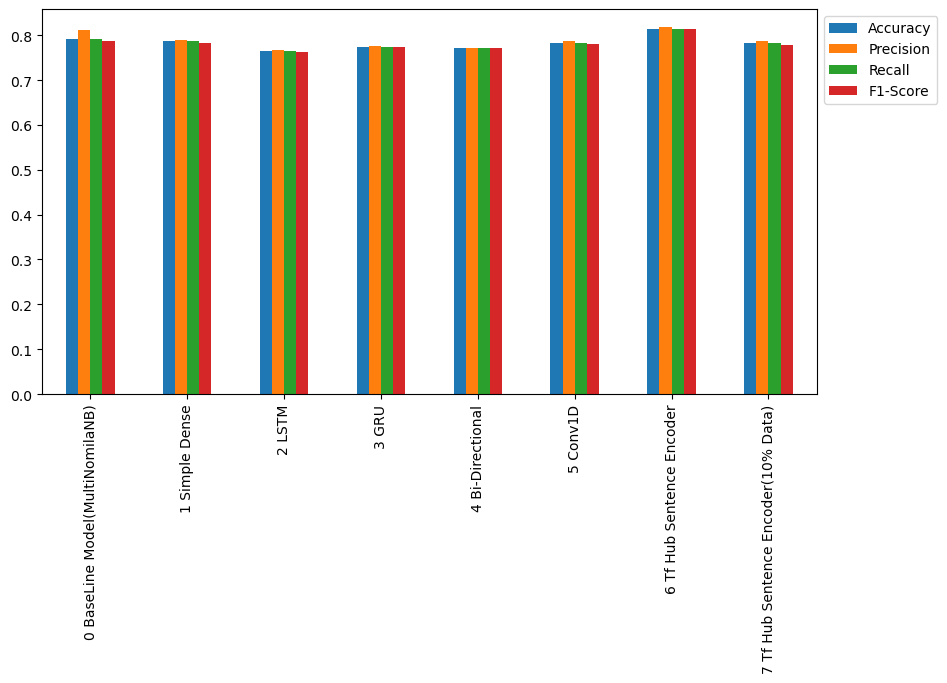

In [128]:
# Plotting All Model's Performance Metrics:
all_model_results.plot(kind= "bar", figsize= (10,5)).legend(bbox_to_anchor= (1,1))

<Axes: >

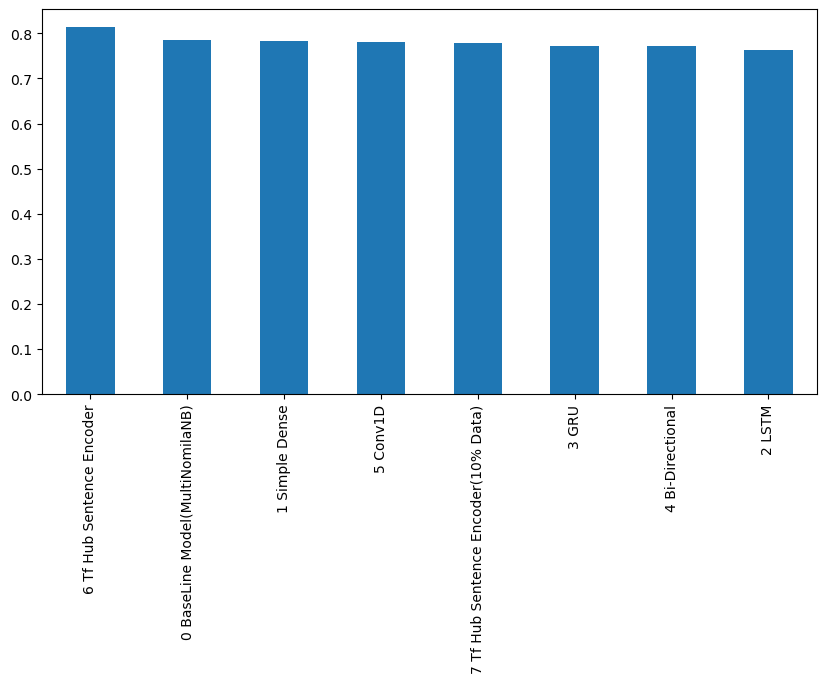

In [129]:
# Sort model results by f1-score
all_model_results.sort_values("F1-Score", ascending= False)["F1-Score"].plot(kind= "bar", figsize= (10,5))

### Comparing Model's Performance on TensorBoard:

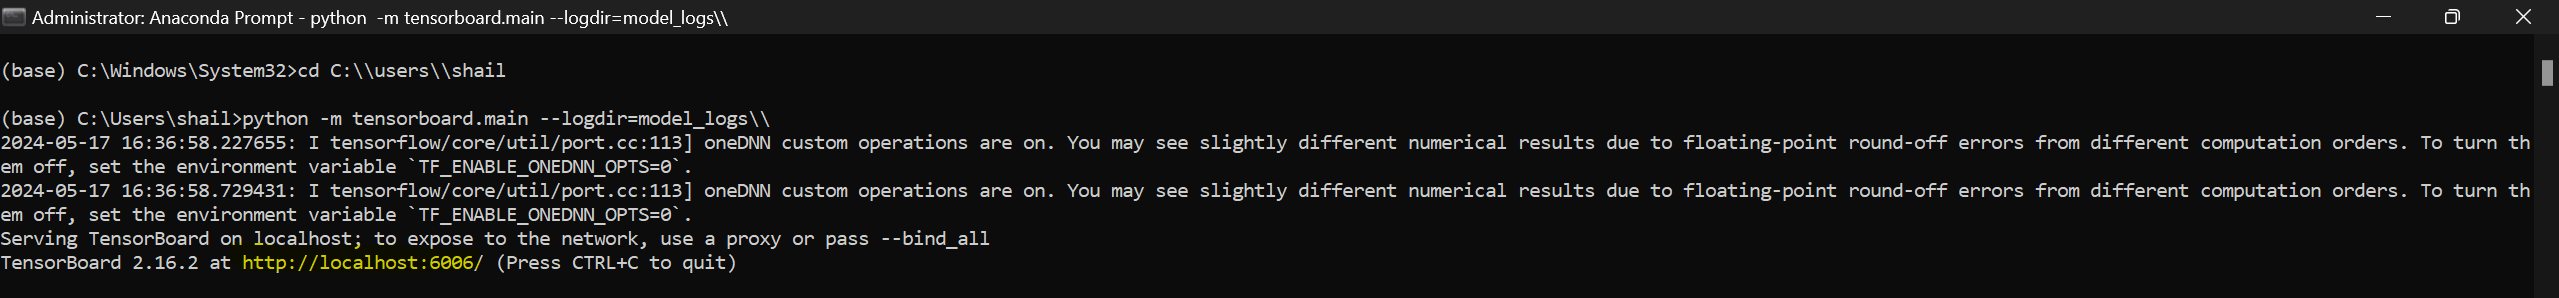

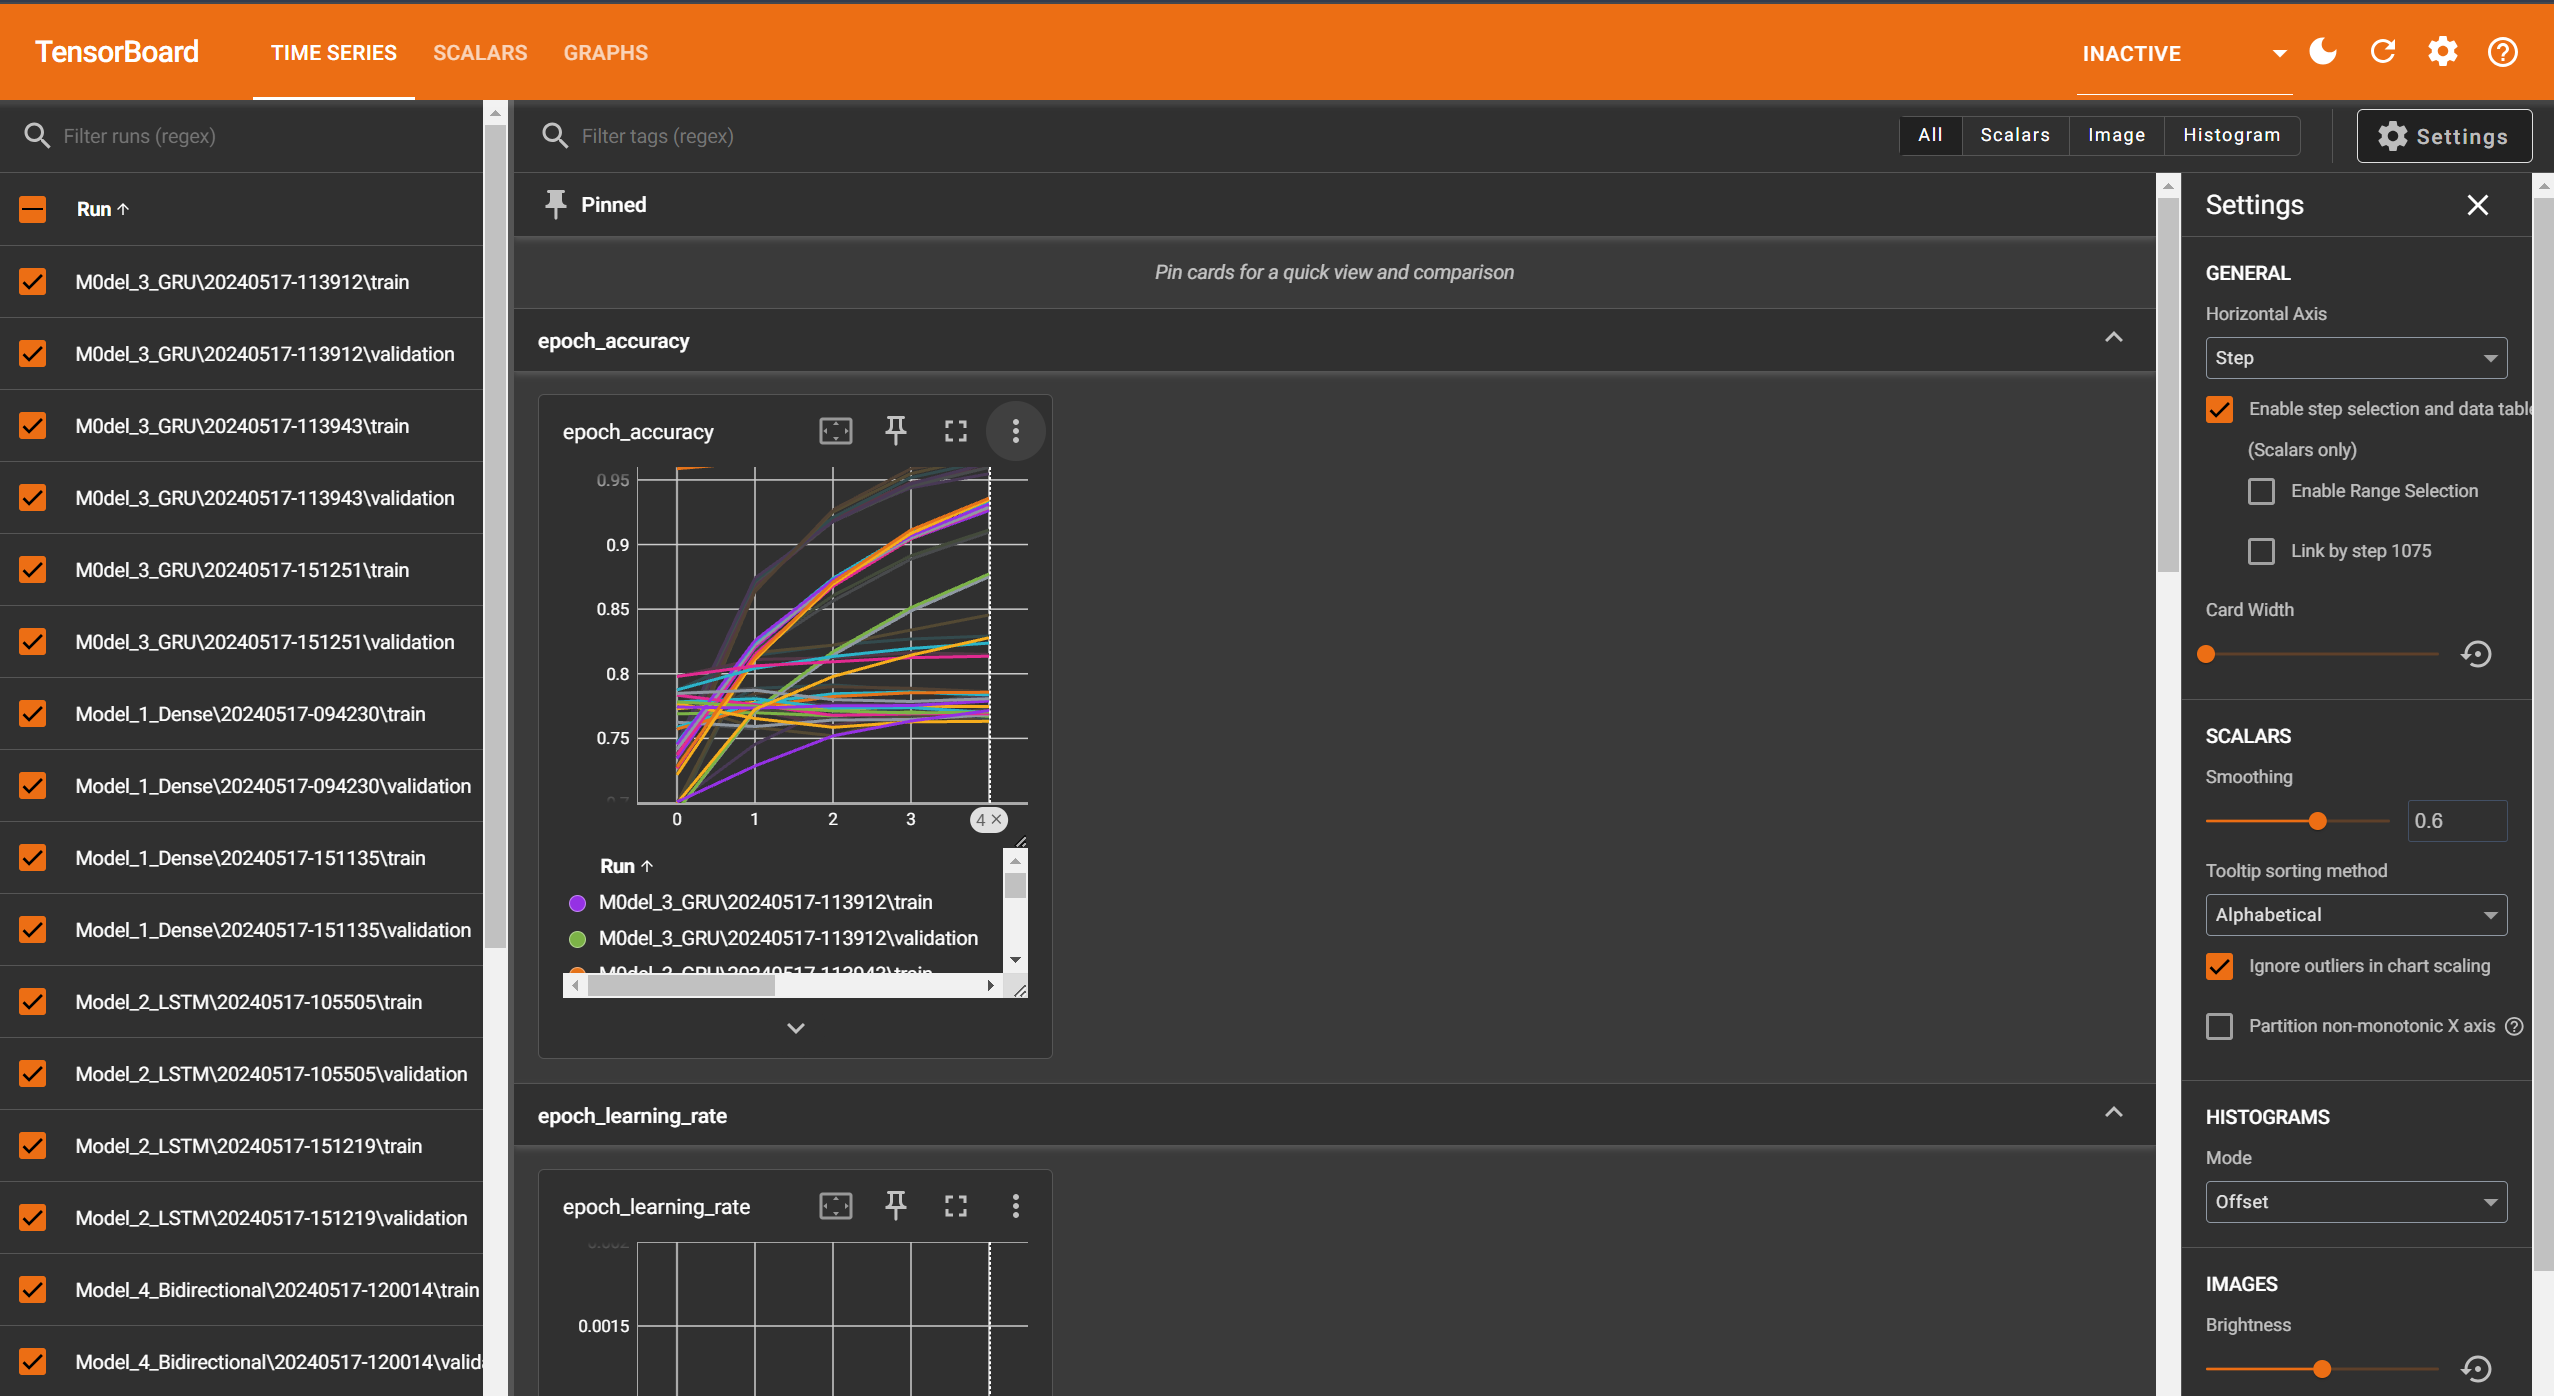

## Saving and loading a trained model

Although training time didn't take very long, it's good practice to save your trained models to avoid having to retrain them.

Saving your models also enables you to export them for use elsewhere outside of your notebooks, such as in a web application.

There are two main ways of [saving a model in TensorFlow](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):
1. The `HDF5` format. 
2. The `SavedModel` format (default).

Let's take a look at both.

In [130]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("Model_6.h5")

C:\Users\shail\AppData\Roaming\Python\Python311\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


If you save a model as a `HDF5`, when loading it back in, you need to let [TensorFlow know about any custom objects you've used](https://www.tensorflow.org/tutorials/keras/save_and_load#saving_custom_objects) (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).

In [132]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("Model_6.h5",
                                           custom_objects= {"KerasLayer": hub.KerasLayer})

In [134]:
# Evaluating Loaded Model:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4291 - accuracy: 0.8150


[0.42907997965812683, 0.8149606585502625]

In [135]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("Model_6_(SavedModel)")

INFO:tensorflow:Assets written to: Model_6_(SavedModel)\assets


INFO:tensorflow:Assets written to: Model_6_(SavedModel)\assets


If you use SavedModel format (default), you can reload your model without specifying custom objects using the [`tensorflow.keras.models.load_model()`](https://www.tensorflow.org/tutorials/keras/save_and_load) function.

In [136]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("Model_6_(SavedModel)")

In [137]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4291 - accuracy: 0.8150


[0.42907997965812683, 0.8149606585502625]

## Finding the most wrong examples

We mentioned before that if many of our modelling experiments are returning similar results, despite using different kinds of models, it's a good idea to return to the data and inspect why this might be.

One of the best ways to inspect your data is to sort your model's predictions and find the samples it got *most* wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

Once again, visualization is your friend.

To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

* If our best model still isn't perfect, what examples is it getting wrong? 
* Which ones are the *most* wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this.

In [139]:
# Create dataframe with validation sentences and best performing model predictions:
validation_df = pd.DataFrame({"Text": val_sentences,
                             "Real Label": val_labels,
                             "Predicted Label": model_6_preds,
                             "Predicted Probability": tf.squeeze(model_6_pred_prob)})

In [140]:
validation_df.head(10)

,Text,Real Label,Predicted Label,Predicted Probability
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.149516
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.760688
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987564
3,@camilacabello97 Internally and externally scr...,1,0.0,0.190244
4,Radiation emergency #preparedness starts with ...,1,1.0,0.759747
5,Investigators rule catastrophic structural fai...,1,1.0,0.666065
6,How the West was burned: Thousands of wildfire...,1,1.0,0.979807
7,Map: Typhoon Soudelor's predicted path as it a...,1,1.0,0.976990
8,Ûª93 blasts accused Yeda Yakub dies in Karach...,1,1.0,0.927404
9,My ears are bleeding https://t.co/k5KnNwugwT,0,0.0,0.090869


In [142]:
# Find the wrong predictions and sort by prediction probabilities:
most_wrong = validation_df[validation_df["Real Label"] != validation_df["Predicted Label"]].sort_values("Predicted Probability", ascending= False)
most_wrong.head(10) # False Positives

,Text,Real Label,Predicted Label,Predicted Probability
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.923837
759,FedEx will no longer transport bioterror patho...,0,1.0,0.874315
628,@noah_anyname That's where the concentration c...,0,1.0,0.856004
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.846203
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.844667
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.818510
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.802768
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.792218
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.780169
144,The Sound of Arson,0,1.0,0.768842


Because we've sorted our samples by prediction probability, viewing samples from the head of our `most_wrong` DataFrame will show us False Positives. While viewing samples from tail of our 'most_wrong' DataFrame will show us False Negatives.

A reminder:
* `0` = Not a real diaster Tweet
* `1` = Real diaster Tweet

In [143]:
most_wrong.tail(10) # False Negatives

,Text,Real Label,Predicted Label,Predicted Probability
221,going to redo my nails and watch behind the sc...,1,0.0,0.062328
361,Next May I'll be free...from school from oblig...,1,0.0,0.061059
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.056739
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.054784
59,You can never escape me. Bullets don't harm me...,1,0.0,0.051711
233,I get to smoke my shit in peace,1,0.0,0.047717
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.038518
38,Why are you deluged with low self-image? Take ...,1,0.0,0.036600
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.035585
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.031847


In [144]:
# Check the False Positives (model predicted 1 when should've been 0):

for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
    _, text, target, prediction, probability = row
    print(f"Target: {target}, Prediction: {prediction}, Prediction Probability: {probability}")
    print(f"Text:\n {text}\n")
    print("---\n")

Target: 0, Prediction: 1.0, Prediction Probability: 0.923837423324585
Text:
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

---

Target: 0, Prediction: 1.0, Prediction Probability: 0.874314546585083
Text:
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

---

Target: 0, Prediction: 1.0, Prediction Probability: 0.8560039401054382
Text:
 @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

---

Target: 0, Prediction: 1.0, Prediction Probability: 0.8462032675743103
Text:
 @madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

---

Target: 0, Prediction: 1.0, Prediction Probability: 0.8446668386459351
Text:
 @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

Target: 0, Prediction: 1.0, Prediction Probability: 0.8185104727745056
Text:
 Ashes 2015: A

In [145]:
# Check the False Negatives (model predicted 0 when should've been 1):

for row in most_wrong[-10:].itertuples(): # loop through the top 10 rows (change the index to view different rows)
    _, text, target, prediction, probability = row
    print(f"Target: {target}, Prediction: {prediction}, Prediction Probability: {probability}")
    print(f"Text:\n {text}\n")
    print("---\n")

Target: 1, Prediction: 0.0, Prediction Probability: 0.06232762336730957
Text:
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy

---

Target: 1, Prediction: 0.0, Prediction Probability: 0.06105887517333031
Text:
 Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...

---

Target: 1, Prediction: 0.0, Prediction Probability: 0.05673876404762268
Text:
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

---

Target: 1, Prediction: 0.0, Prediction Probability: 0.05478362739086151
Text:
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

---

Target: 1, Prediction: 0.0, Prediction Probability: 0.051710713654756546
Text:
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

---

Tar

## Making predictions on the test dataset

We've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

In [146]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [148]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6.predict([test_sample]))
    pred = tf.round(pred_prob)
    print(f"Prediction: {int(pred)}, Probability: {pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("----\n")

1/1 [==============================] - 0s 93ms/step
Prediction: 0, Probability: 0.18323221802711487
Text:
ÛÏEven in the midst of devastation something within us always points the way to freedom.Û

----

1/1 [==============================] - 0s 91ms/step
Prediction: 1, Probability: 0.7659624218940735
Text:
#Tajikistan #Mudslides #China aids to #Mudslide-hit #Tajiks http://t.co/BD546mtcpN

----

1/1 [==============================] - 0s 69ms/step
Prediction: 1, Probability: 0.5774278044700623
Text:
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her
 
#FARRAKHAN #QUOTE

----

1/1 [==============================] - 0s 50ms/step
Prediction: 0, Probability: 0.1441805511713028
Text:
Bat four reasons en route to upheaval versus internet buzz value: pVDRDLJvc

----

1/1 [==============================] - 0s 62ms/step
Prediction: 0, Probability: 0.09455191344022751
Text:
@yourgirlhaileyy leaveevacuateexitbe banished.

----

1

It's important to do these kind of visualization checks as often as possible to get a glance of how your model performs on unseen data and subsequently how it might perform on the real test: Tweets from the wild.

## Predicting on Tweets from the wild

How about we find some Tweets and use our model to predict whether or not they're about a diaster or not?

In [149]:
# making a Function to take in a Model and a Sentence to classify the sentence as Disaster or 
# Not Disaster using The Model:

def predict_on_sentence(model, sentence):
    """
      Uses model to make a prediction on sentence.

      Returns the sentence, the predicted label and the prediction probability.
    """
    
    pred_prob = model.predict([sentence])
    pred = tf.squeeze(tf.round(pred_prob))
    print(f"Predicted Label: {pred}", "(Real Disaster)" if pred > 0 else "(Not Real Disaster)", 
          f"Prob: {pred_prob[0][0]}")
    print(f"Text: \n{sentence}")

In [150]:
shailyas_tweet = "That's what makes a ride complete.The symbol of Greatest Gladiator Match in History of the World. @BatmanvSuperman"

In [151]:
# making a Prediction on Given Sentence:
predict_on_sentence(model_6, shailyas_tweet)

1/1 [==============================] - 0s 45ms/step
Predicted Label: 0.0 (Not Real Disaster) Prob: 0.3423294126987457
Text: 
That's what makes a ride complete.The symbol of Greatest Gladiator Match in History of the World. @BatmanvSuperman


In [152]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [153]:
predict_on_sentence(model_6, beirut_tweet_1)

1/1 [==============================] - 0s 97ms/step
Predicted Label: 1.0 (Real Disaster) Prob: 0.9636288285255432
Text: 
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [154]:
predict_on_sentence(model_6, beirut_tweet_2)

1/1 [==============================] - 0s 38ms/step
Predicted Label: 1.0 (Real Disaster) Prob: 0.9717369079589844
Text: 
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


## The speed/score tradeoff

One of the final tests we're going to do is to find the speed/score tradeoffs between our best model and baseline model.

Although it can be tempting to just choose the best performing model you find through experimentation, this model might not actually work in a production setting.

Put it this way, imagine you're Twitter and receive 1 million Tweets per hour (this is a made up number, the actual number is much higher). And you're trying to build a diaster detection system to read Tweets and alert authorities with details about a diaster in close to real-time.

Compute power isn't free so you're limited to a single compute machine for the project. On that machine, one of your models makes 10,000 predictions per second at 80% accuracy where as another one of your models (a larger model) makes 100 predictions per second at 85% accuracy.

Which model do you choose?

Is the second model's performance boost worth missing out on the extra capacity?

Of course, there are many options you could try here, such as sending as many Tweets as possible to the first model and then sending the ones which the model is least certain of to the second model. 

The point here is to illustrate the best model you find through experimentation, might not be the model you end up using in production.

Let's write a function to take a model and a number of samples and time how long the given model takes to make predictions on those samples.

In [156]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples) # find prediction time per sample
  return total_time, time_per_pred

In [157]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 14ms/step


(0.482959100001608, 0.0006338045931779633)

In [158]:
# Calculate Baseline Model's (Naive Bayes) prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.03319619999092538, 4.356456691722491e-05)

Let's compare time per prediction versus our model's F1-scores.

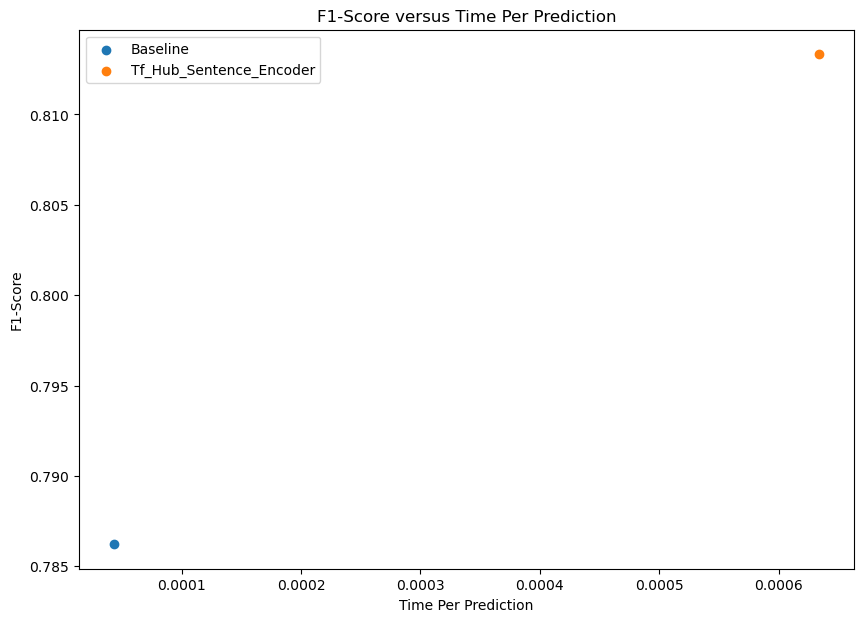

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["F1-Score"], label="Baseline")
plt.scatter(model_6_time_per_pred, model_6_results["F1-Score"], label="Tf_Hub_Sentence_Encoder")
plt.legend()
plt.title("F1-Score versus Time Per Prediction")
plt.xlabel("Time Per Prediction")
plt.ylabel("F1-Score");

The ideal position for each of these dots is to be in the top left of the plot (low time per prediction, high F1-score). 

In our case, there's a clear tradeoff for time per prediction and performance. Our best performing model takes an order of magnitude longer per prediction but only results in a few F1-score point increase.

This kind of tradeoff is something you'll need to keep in mind when incorporating machine learning models into your own applications.